In [41]:
import numpy as np
import pandas as pd
import os
import torch
from torch.autograd import Variable
from matplotlib import pyplot as plt
%matplotlib inline

In [42]:
import sys
sys.path.append("../Network-SDE-Inference/utils")
import NeuGNN_model
import Self_func
import Interaction_func
from NeuGNN_model import *
from Self_func import *
from Interaction_func import *

In [43]:
USE_CUDA = False

In [44]:
Timeseries = pd.read_csv('../Network-SDE-Inference/Data/Time series/flocks_timeseries_2dim_hf4.csv',encoding='utf-8',header=None)

In [45]:
Adj = pd.read_csv('../Network-SDE-Inference/Data/Topology/hf4_matrix.csv',encoding='utf-8',header=None)

In [46]:
model = 'flocks'

In [47]:
Num_nodes = Adj.shape[0]
Dimension = int(Timeseries.shape[1]/Num_nodes)

In [48]:
time = Timeseries.values
timeseries = time.reshape(( -1, Num_nodes, Dimension)) # checked, correct input data

In [49]:
delt_t = 0.01

In [50]:
timeseries_t0 = timeseries[0:-1,:,:]
timeseries_t1 = timeseries[1:,:,:]
dX = (timeseries_t1-timeseries_t0)
dXdt = (timeseries_t1-timeseries_t0)/delt_t

In [51]:
timeseries_t2 = timeseries[2:,:,:]
dVdt = (timeseries_t2-2*timeseries_t1[:-1,:,:]+timeseries[0:-2,:,:])/delt_t**2

In [52]:
import numpy as np
def get_edge_index(Adj):
    num_nodes = Adj.shape[0]
    Adj = Adj.values
    edge_index = torch.from_numpy(np.array(np.where(Adj)))
    return edge_index

In [53]:
edge_index = get_edge_index(Adj) #target to source

index = [1,0]
edge_index = edge_index[index] #source to target 
# checked, correct input edge_index data

In [54]:
#data = data.reshape((10,-1,4,6))
import numpy as np
goal_data = np.concatenate([timeseries[3:,:,:],dXdt[1:-1,:,:],dVdt[:-1,:,:]],axis=2)
#goal_data = data[1:-1,:,0:Dimension]
mapping_data = np.concatenate((timeseries[1:-2,:,:],dXdt[0:-2,:,:]),axis=2)

In [55]:
X = torch.as_tensor(np.array(mapping_data).astype('float'))
y = torch.as_tensor(np.array(goal_data).astype('float'))

In [56]:
from sklearn.model_selection import train_test_split

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2)
X_train = X_train.float()
y_train = y_train.float()
X_test = X_test.float()
y_test = y_test.float()

In [58]:
import torch
from torch import nn
from torch.functional import F
from torch.optim import Adam
from torch_geometric.nn import MetaLayer, MessagePassing

In [59]:
aggr = 'add'
hidden = 100


msg_dim = 3
n_f = mapping_data.shape[2]

In [60]:
dim = Dimension*1

In [61]:
from torch_geometric.data import Data, DataLoader

## Define the network, also can import from utils file (uncomment first)

In [62]:
class SDIdifftype(MessagePassing):
    def __init__(self, model, n_f, msg_dim, ndim, delt_t,hidden=50, aggr='add', flow='source_to_target'):

        """If flow is 'source_to_target', the relation is (j,i), means information is passed from x_j to x_i'"""
        super(SDIdifftype, self).__init__(aggr=aggr, flow=flow)
        self.msg_fnc_cohesion = Seq(
            Lin(1,hidden),
            ReLU(),
            Lin(hidden,hidden),
            ReLU(),
            Lin(hidden,hidden),
            ReLU(),
            Lin(hidden,1)
            #Softplus()
        )
        for layer in self.msg_fnc_cohesion:
            if isinstance(layer,nn.Linear):
                param_shape = layer.weight.shape
                torch.nn.init.normal_(layer.weight, mean=0.0, std = 1e-1)
           
        self.msg_fnc_align = Seq(
            Lin(1,hidden),
            ReLU(),
            Lin(hidden,hidden),
            ReLU(),
            Lin(hidden,hidden),
            ReLU(),
            Lin(hidden,1)
            #Softplus()
        )
        for layer in self.msg_fnc_align:
            if isinstance(layer,nn.Linear):
                param_shape = layer.weight.shape
                torch.nn.init.normal_(layer.weight, mean=0.0, std = 1e-1)
                
        self.msg_fnc_repulsion = Seq(
            Lin(1,hidden),
            ReLU(),
            Lin(hidden,hidden),
            ReLU(),
            Lin(hidden,hidden),
            ReLU(),
            Lin(hidden,1),
            Sigmoid()
        )
        for layer in self.msg_fnc_repulsion:
            if isinstance(layer,nn.Linear):
                param_shape = layer.weight.shape
                torch.nn.init.normal_(layer.weight, mean=0.0, std = 1e-1)
                
        self.node_fnc_strength_x = Seq(
            Lin(2,hidden),
            ReLU(),
            Lin(hidden,hidden),
            ReLU(),
            Lin(hidden,hidden),
            ReLU(),
            Lin(hidden,1)
        )
        
        for layer in self.node_fnc_strength_x:
            if isinstance(layer,nn.Linear):
                param_shape = layer.weight.shape
                torch.nn.init.normal_(layer.weight, mean=0.0, std = 1e-1)
        
        self.node_fnc_strength_y = Seq(
            Lin(2,hidden),
            ReLU(),
            Lin(hidden,hidden),
            ReLU(),
            Lin(hidden,hidden),
            ReLU(),
            Lin(hidden,1)
        )
        
        for layer in self.node_fnc_strength_y:
            if isinstance(layer,nn.Linear):
                param_shape = layer.weight.shape
                torch.nn.init.normal_(layer.weight, mean=0.0, std = 1e-1)

        self.stochastic_x = Seq(
            Lin(ndim*2,hidden),
            ReLU(),
            Lin(hidden,1),
            Softplus()
        )
        for layer in self.stochastic_x:
            if isinstance(layer,nn.Linear):
                param_shape = layer.weight.shape
                torch.nn.init.normal_(layer.weight, mean=0.0, std=1e-3)
                
        self.stochastic_y = Seq(
            Lin(ndim*2,hidden),
            ReLU(),
            Lin(hidden,1),
            Softplus()
        )
        for layer in self.stochastic_y:
            if isinstance(layer,nn.Linear):
                param_shape = layer.weight.shape
                torch.nn.init.normal_(layer.weight, mean=0.0, std=1e-3)

        
        self.stochastic_z = Seq(
            Lin(ndim*2,hidden),
            ReLU(),
            Lin(hidden,1),
            Softplus()
        )
        for layer in self.stochastic_z:
            if isinstance(layer,nn.Linear):
                param_shape = layer.weight.shape
                torch.nn.init.normal_(layer.weight, mean=0.0, std=1e-3)
               

    def forward(self, x, edge_index):
        # x has shape [N, number_of_features]
        # edge_index has shape [2,E]
        x = x
        return self.propagate(edge_index, x=x)

    def message(self, x_i, x_j):
        tmp = torch.cat([x_i, x_j], dim=1)
        if self.ndim == 1:
            xij = x_j[:,0]-x_i[:,0]
            Rij = xij.reshape(-1,1)
            vxij = x_j[:,1]-x_i[:,1]
            vij = vxij.reshape(-1,1)
            rij = torch.sqrt(xij**2)
        if self.ndim == 2:
            xij = x_j[:,0]-x_i[:,0]
            yij = x_j[:,1]-x_i[:,1]
            vxij = x_j[:,2]-x_i[:,2]
            vyij = x_j[:,3]-x_i[:,3]
            Rij = torch.cat([xij.reshape(-1,1), yij.reshape(-1,1)], dim=1)
            vij = torch.cat([vxij.reshape(-1,1), vyij.reshape(-1,1)], dim=1)
            rij = torch.sqrt(xij**2+yij**2)
            zero = torch.zeros_like(rij)
            one = torch.ones_like(rij)
            vision = torch.where(rij>0.1,zero,one)
            #print(vision)
        if self.ndim == 3:
            xij = x_j[:,0]-x_i[:,0]
            yij = x_j[:,1]-x_i[:,1]
            zij = x_j[:,2]-x_i[:,2]
            vxij = x_j[:,3]-x_i[:,3]
            vyij = x_j[:,4]-x_i[:,4]
            vzij = x_j[:,5]-x_i[:,5]
            Rij = torch.cat([xij.reshape(-1,1), yij.reshape(-1,1),zij.reshape(-1,1)], dim=1)
            vij = torch.cat([vxij.reshape(-1,1), vyij.reshape(-1,1),vzij.reshape(-1,1)], dim=1)
            rij = torch.sqrt(xij**2+yij**2+zij**2)

        Message = self.msg_fnc_cohesion(rij.reshape(-1,1))*Rij*vision.reshape(-1,1)+self.msg_fnc_align(rij.reshape(-1,1))*vij*vision.reshape(-1,1)#+self.msg_fnc_repulsion(rij.reshape(-1,1))*Rij
        #print(torch.sum(self.msg_fnc_cohesion(rij)))
        return Message
    

    def update(self, aggr_out, x=None):
        if self.ndim==1:
            vxi = x[:,1]
            vi = vxi.reshape(-1,1)
            Vi = torch.sqrt(vxi**2)
            F = self.node_fnc_strength(Vi.reshape(-1,1))
            dvdt = F*vi+aggr_out
            v_update = x[:,self.ndim:]+dvdt*self.delt_t
            v_mean = x[:,self.ndim:]+dvdt*self.delt_t
            v_var_x = self.stochastic_x(x)
            x_update = x[:,:self.ndim]+x[:,self.ndim:]*self.delt_t+v_update*self.delt_t
            return torch.distributions.Normal(v_mean, v_var_x),x_update,v_update,dvdt
        elif self.ndim==2:
            vxi = x[:,2]
            vyi = x[:,3]
            vi = torch.cat([vxi.reshape(-1,1),vyi.reshape(-1,1)],dim=1)
            Vi = torch.sqrt(vxi**2+vyi**2)
            Vx = torch.cat([Vi.reshape(-1,1),vxi.reshape(-1,1)],dim=1)
            Vy = torch.cat([Vi.reshape(-1,1),vyi.reshape(-1,1)],dim=1)
            Fx = self.node_fnc_strength_x(Vx)
            Fy = self.node_fnc_strength_y(Vy)
            F = torch.cat((Fx,Fy),dim=1)
            #dvdt = F*vi+aggr_out
            dvdt = F+aggr_out
            v_update = x[:,self.ndim:]+dvdt*self.delt_t
            v_mean = x[:,self.ndim:]+dvdt*self.delt_t
            v_var_x = self.stochastic_x(x)
            v_var_y = self.stochastic_y(x)
            x_update = x[:,:self.ndim]+x[:,self.ndim:]*self.delt_t+v_update*self.delt_t
            return torch.distributions.Normal(v_mean[:,0].reshape(-1,1), v_var_x),torch.distributions.Normal(v_mean[:,1].reshape(-1,1), v_var_y),x_update,v_update,dvdt
        elif self.ndim==3:
            vxi = x[:,3]
            vyi = x[:,4]
            vzi = x[:,5]
            vi = torch.cat([vxi.reshape(-1,1),vyi.reshape(-1,1),vzi.reshape(-1,1)],dim=1)
            Vi = vxi**2+vyi**2+vzi**2
            F = self.node_fnc_strength(Vi.reshape(-1,1))
            dvdt = F*vi+aggr_out
            v_update = x[:,self.ndim:]+dvdt*self.delt_t
            v_mean = x[:,self.ndim:]+dvdt*self.delt_t
            v_var_x = self.stochastic_x(x)
            v_var_y = self.stochastic_y(x)
            v_var_z = self.stochastic_z(x)
            x_update = x[:,:self.ndim]+x[:,self.ndim:]*self.delt_t+v_update*self.delt_t
            return torch.distributions.Normal(v_mean[:,0].reshape(-1,1), v_var_x),torch.distributions.Normal(v_mean[:,1].reshape(-1,1), v_var_y),torch.distributions.Normal(v_mean[:,2].reshape(-1,1), v_var_z),x_update,v_update,dvdt



class SDI_Difftype(SDIdifftype):
     def __init__(
 		self, model, n_f, msg_dim, ndim, delt_t,
 		edge_index, aggr='add', hidden=50, nt=1):
            super(SDI_Difftype, self).__init__(model, n_f, msg_dim, ndim, delt_t, hidden=hidden, aggr=aggr)
            self.delt_t = delt_t
            self.nt = nt
            self.edge_index = edge_index
            self.ndim = ndim

    
     def SDI_weighted(self, g, augment=False, augmentation=3):
            #x is [n, n_f]f
            x = g.x
            ndim = self.ndim
            if augment:
                augmentation = torch.randn(1, ndim)*augmentation
                augmentation = augmentation.repeat(len(x), 1).to(x.device)
                x = x.index_add(1, torch.arange(ndim).to(x.device), augmentation)
        
            edge_index = g.edge_index
            return self.propagate(
                    edge_index, size=(x.size(0), x.size(0)),
                    x=x)

     def loss(self, g, **kwargs):
            if self.ndim==1:
                out_dist_x,xUpdate,vUpdate,a_est = self.SDI_weighted(g)
                neg_log_likelihood_x = -out_dist_x.log_prob(g.y[:,1].reshape(-1,1))
                x_loss = torch.sum((g.y[:,0] - xUpdate)**2)
                v_loss = torch.sum((g.y[:,1] - vUpdate)**2)
                a_loss = torch.sum((g.y[:,2] - a_est)**2)
                dis_loss = torch.sum(neg_log_likelihood_x)
                #print(x_loss,v_loss,a_loss,dis_loss)
                return dis_loss*1e-2+a_loss*1e4#+x_loss*1e6+v_loss*1e6
            if self.ndim==2:
                out_dist_x,out_dist_y,xUpdate,vUpdate,a_est = self.SDI_weighted(g)
                neg_log_likelihood_x = -out_dist_x.log_prob(g.y[:,2].reshape(-1,1))
                neg_log_likelihood_y = -out_dist_y.log_prob(g.y[:,3].reshape(-1,1))
                x_loss = torch.sum((g.y[:,:2] - xUpdate)**2)
                v_loss = torch.sum((g.y[:,2:4] - vUpdate)**2)
                a1_loss = torch.sum((g.y[:,4] - a_est[:,0])**2)
                a2_loss = torch.sum((g.y[:,5] - a_est[:,1])**2)
                dis_loss = torch.sum(neg_log_likelihood_x)+torch.sum(neg_log_likelihood_y)
                #print(g.y[:,6:])
                #print(a_est)
                #print(x_loss,v_loss,a1_loss,a2_loss,dis_loss)
                return dis_loss+a1_loss*3e3+a2_loss*1e3+x_loss*1e6+v_loss*1e6
            if self.ndim==3:
                out_dist_x,out_dist_y,out_dist_z,xUpdate,vUpdate,a_est = self.SDI_weighted(g)
                neg_log_likelihood_x = -out_dist_x.log_prob(g.y[:,3].reshape(-1,1))
                neg_log_likelihood_y = -out_dist_y.log_prob(g.y[:,4].reshape(-1,1))
                neg_log_likelihood_z = -out_dist_x.log_prob(g.y[:,5].reshape(-1,1))
                x_loss = torch.sum((g.y[:,:3] - xUpdate)**2)
                v_loss = torch.sum((g.y[:,3:6] - vUpdate)**2)
                a_loss = torch.sum((g.y[:,6:] - a_est)**2)
                dis_loss = torch.sum(neg_log_likelihood_x)+torch.sum(neg_log_likelihood_y)+torch.sum(neg_log_likelihood_z)
                #print(g.y[:,6:])
                #print(a_est)
                #print(x_loss,v_loss,a_loss,dis_loss)
                return dis_loss+a_loss*1e6+x_loss*1e6+v_loss*1e6
                #return dis_loss
     def sample_trajectories(self, g, **kwargs):
            if self.ndim == 1:
                out_dist_x,xUpdate,vUpdate,a_est = self.SDI_weighted(g)
                vxUpdate_sample = out_dist_x.sample()
                vUpdate_sample = vxUpdate_sample.reshape(-1,1)
                xUpdate_sample = g.x[:,0].reshape(-1,1)+g.x[:,1].reshape(-1,1)*delt_t+vUpdate_sample*delt_t
                return xUpdate_sample,vUpdate_sample
            if self.ndim == 2:
                out_dist_x,out_dist_y,xUpdate,vUpdate,a_est = self.SDI_weighted(g)
                vxUpdate_sample = out_dist_x.sample()
                vyUpdate_sample = out_dist_y.sample()
                vUpdate_sample = torch.cat((vxUpdate_sample.reshape(-1,1),vyUpdate_sample.reshape(-1,1)),dim=1)
                xUpdate_sample = g.x[:,0:2].reshape(-1,2)+g.x[:,2:4].reshape(-1,2)*delt_t+vUpdate_sample*delt_t
                return xUpdate_sample,vUpdate_sample
            if self.ndim == 3:
                out_dist_x,out_dist_y,out_dist_z,xUpdate,vUpdate,a_est = self.SDI_weighted(g)
                vxUpdate_sample = out_dist_x.sample()
                vyUpdate_sample = out_dist_y.sample()
                vzUpdate_sample = out_dist_z.sample()
                vUpdate_sample = torch.cat((vxUpdate_sample.reshape(-1,1),vyUpdate_sample.reshape(-1,1),vzUpdate_sample.reshape(-1,1)),dim=1)
                xUpdate_sample = g.x[:,0:3].reshape(-1,3)+g.x[:,3:6].reshape(-1,3)*delt_t+vUpdate_sample*delt_t
                return xUpdate_sample,vUpdate_sample
     def average_trajectories(self, g, **kwargs):
            if self.ndim == 1:
                out_dist_x,xUpdate,vUpdate,a_est = self.SDI_weighted(g)
                return xUpdate,vUpdate
            if self.ndim == 2:
                out_dist_x,out_dist_y,xUpdate,vUpdate,a_est = self.SDI_weighted(g)
                return xUpdate,vUpdate
            if self.ndim == 3:
                out_dist_x,out_dist_y,out_dist_z,xUpdate,vUpdate,a_est = self.SDI_weighted(g)
                return xUpdate,vUpdate

In [63]:
ogn = SDI_Difftype(model,n_f, msg_dim, dim, delt_t, hidden=hidden, edge_index=edge_index , aggr=aggr)

In [64]:
messages_over_time = []
selfDyn_over_time = []
diffusion_over_time = []

In [65]:
x=X_train[1]
y=y_train[1]
_q = Data(
    x=X_train[1],
    edge_index=edge_index,
    y=y_train[1])

In [66]:
ogn.loss(_q)

tensor(1171.7961, grad_fn=<AddBackward0>)

In [67]:
batch = 64
trainloader = DataLoader(
    [Data(
        Variable(X_train[i]),
        edge_index=edge_index,
        y=Variable(y_train[i])) for i in range(len(y_train))],
    batch_size=batch,
    shuffle=True
)

testloader = DataLoader(
    [Data(
        X_test[i],
        edge_index=edge_index,
        y=y_test[i]) for i in range(len(y_test))],
    batch_size=128,
    shuffle=True
)

/opt/anaconda3/envs/pytorch_env/lib/python3.8/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [68]:
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR

In [69]:
init_lr = 1e-4

opt = torch.optim.Adam(ogn.parameters(), lr=init_lr, weight_decay=1e-8)

# total_epochs = 200
total_epochs = 30

batch_per_epoch = 2000

sched = OneCycleLR(opt, max_lr=init_lr,
                   steps_per_epoch=batch_per_epoch,#len(trainloader),
                   epochs=total_epochs, final_div_factor=1e5)

In [70]:
epoch = 0
from tqdm import tqdm

In [71]:
import numpy as onp
onp.random.seed(0)
test_idxes = onp.random.randint(0, len(X_test), 1000)

#Record messages over test dataset here:
newtestloader = DataLoader(
     [Data(
         X_test[i],
         edge_index=edge_index,
         y=y_test[i]) for i in test_idxes],
     batch_size=len(X_test),
     shuffle=False
 )

In [72]:
import numpy as onp
import pandas as pd

def get_messages(ogn):

    def get_message_info(tmp):
        ogn.cpu()

        s1 = tmp.x[tmp.edge_index[0]] #source

        s2 = tmp.x[tmp.edge_index[1]] #target

        #Tmp = torch.cat([s2, s1],dim=1) # tmp --> xi,xj
        xtmp = (s1[:,0:dim]-s2[:,0:dim])
        vtmp = (s1[:,dim:dim*2]-s2[:,dim:dim*2])
        if dim == 1:
            Xtmp = torch.sqrt((s1[:,0]-s2[:,0])**2)
        if dim == 2:
            Xtmp = torch.sqrt((s1[:,0]-s2[:,0])**2+(s1[:,1]-s2[:,1])**2)
        if dim == 3:
            Xtmp = torch.sqrt((s1[:,0]-s2[:,0])**2+(s1[:,1]-s2[:,1])**2+(s1[:,2]-s2[:,2])**2)
 
        cohesion = ogn.msg_fnc_cohesion(Xtmp.reshape(-1,1))
        align = ogn.msg_fnc_align(Xtmp.reshape(-1,1))
        #repulsion = ogn.msg_fnc_repulsion(Xtmp.reshape(-1,1))
    
        all_messages = torch.cat((
            xtmp,vtmp,cohesion,align), dim=1)
        if dim == 1:
            columns = ['xij','dxij','c1','a1']
        if dim == 2:
            columns = ['xij','yij','dxij','dyij','c1','a1']
        elif dim == 3:
            columns = ['xij','yij','zij','dxij','dyij','dzij','c1','a1']

        return pd.DataFrame(
              data=all_messages.cpu().detach().numpy(),
             columns=columns
        )
        #print(all_messages.shape)
        return pd.DataFrame(all_messages)

    msg_info = []
    for i, g in enumerate(newtestloader):
        msg_info.append(get_message_info(g))

    msg_info = pd.concat(msg_info)
    
    return msg_info

In [73]:
def get_diffusion(ogn):
    def get_diffusion_info(tmp):
        ogn.cpu()
        
        tmp = tmp.x[tmp.edge_index[1]]
        if dim==1:
            self_diff_x = ogn.stochastic_x(tmp)
            self_diff_all = torch.cat((tmp,self_diff_x), dim=1)
            columns = ['xi','dxi','d1']
            
        if dim==2:
            self_diff_x = ogn.stochastic_x(tmp)
            self_diff_y = ogn.stochastic_y(tmp)
            self_diff_all = torch.cat((tmp,self_diff_x,self_diff_y), dim=1)
            columns = ['xi','yi','dxi','dyi','d1','d2']
        if dim==3:
            self_diff_x = ogn.stochastic_x(tmp)
            self_diff_y = ogn.stochastic_y(tmp)
            self_diff_z = ogn.stochastic_z(tmp)
            self_diff_all = torch.cat((tmp,self_diff_x,self_diff_y,self_diff_z), dim=1)
            columns = ['xi','yi','zi','dxi','dyi','dzi','d1','d2','d3']
            
        return pd.DataFrame(
              data=self_diff_all.cpu().detach().numpy(),
             columns=columns
        )
        return pd.DataFrame(self_diff_all)

    selfDiffusion_info = []
    for i, g in enumerate(newtestloader):
        selfDiffusion_info.append(get_diffusion_info(g))

    selfDiffusion_info = pd.concat(selfDiffusion_info)
    return selfDiffusion_info 

In [74]:
def get_selfDynamics(ogn):
    def get_selfDynamics_info(tmp):
        ogn.cpu()
        
        tmp = tmp.x[tmp.edge_index[1]]
        if dim==1:
            vtmp = torch.sqrt(tmp[:,1]**2)
            self_dyn = ogn.node_fnc_strength(vtmp.reshape(-1,1))
            self_dyn_all = torch.cat((tmp[:,1:2],self_dyn), dim=1)
            columns = ['dxi','s1']
            
        if dim==2:
            vtmp = tmp[:,2]**2+tmp[:,3]**2
            vxtmp = torch.cat((vtmp.reshape(-1,1),tmp[:,2].reshape(-1,1)),dim=1)
            vytmp = torch.cat((vtmp.reshape(-1,1),tmp[:,3].reshape(-1,1)),dim=1)
            
            self_dyn_x = ogn.node_fnc_strength_x(vxtmp)#vtmp.reshape(-1,1)
            self_dyn_y = ogn.node_fnc_strength_y(vytmp)#vtmp.reshape(-1,1)
            self_dyn_all = torch.cat((vtmp.reshape(-1,1),tmp[:,2:4],self_dyn_x, self_dyn_y), dim=1)
            columns = ['Vi','dxi','dyi','s1','s2']
        if dim==3:
            vtmp = torch.sqrt(tmp[:,3]**2+tmp[:,4]**2+tmp[:,5]**2)
            self_dyn = ogn.node_fnc_strength(vtmp.reshape(-1,1))
            self_dyn_all = torch.cat((tmp[:,3:6],self_dyn), dim=1)
            columns = ['dxi','dyi','dzi','s1']
            
        return pd.DataFrame(
              data=self_dyn_all.cpu().detach().numpy(),
             columns=columns
        )
        return pd.DataFrame(self_dyn_all)

    selfDyn_info = []
    for i, g in enumerate(newtestloader):
        selfDyn_info.append(get_selfDynamics_info(g))

    selfDyn_info = pd.concat(selfDyn_info)
    return selfDyn_info

In [75]:
recorded_models = []

In [76]:
for epoch in tqdm(range(epoch, total_epochs)):
    ogn
    total_loss = 0.0
    i = 0
    j = 0
    num_items = 0
    valid_loss = 0
    valid_num_items = 0
    while i < batch_per_epoch:
        for ginput in trainloader:
            if i >= batch_per_epoch:
                break
            opt.zero_grad()
            ginput.x = ginput.x
            ginput.y = ginput.y
            ginput.edge_index = ginput.edge_index
            ginput.batch = ginput.batch
            loss = ogn.loss(ginput)
            loss.backward()
            #(loss/int(ginput.batch[-1]+1)).backward()
            opt.step()
            sched.step()

            total_loss += loss.item()
            i += 1
            num_items += int(ginput.batch[-1]+1)
    
    ogn.eval()
    with torch.no_grad():
        while j < batch_per_epoch:
            for ginput in testloader:
                if j>= batch_per_epoch:
                    break
                ginput.x = ginput.x
                ginput.y = ginput.y
                ginput.edge_index = ginput.edge_index
                ginput.batch = ginput.batch
                loss = ogn.loss(ginput)#/int(ginput.batch[-1]+1)
                valid_loss += loss.item()
                valid_num_items += int(ginput.batch[-1]+1)
                j += 1



    cur_loss = total_loss/num_items
    cur_valid_loss = valid_loss/valid_num_items
    print(cur_loss)
    print(cur_valid_loss)
    cur_msgs = get_messages(ogn)
    cur_selfdyn = get_selfDynamics(ogn)
    cur_diff = get_diffusion(ogn)
    cur_msgs['epoch'] = epoch
    cur_msgs['loss'] = cur_loss
    messages_over_time.append(cur_msgs)
    selfDyn_over_time.append(cur_selfdyn)
    diffusion_over_time.append(cur_diff)
    
    ogn.cpu()
    from copy import deepcopy as copy
    recorded_models.append(copy(ogn.state_dict()))

  0%|                                                    | 0/30 [00:00<?, ?it/s]

134.16395797828437
7.42907370736925


  3%|█▍                                         | 1/30 [02:01<58:31, 121.09s/it]

5.443352328548003
2.473130018523738


  7%|██▊                                        | 2/30 [03:55<54:40, 117.18s/it]

-4.324130581961687
-14.37745349815666


 10%|████▎                                      | 3/30 [05:50<52:16, 116.17s/it]

-34.914833790909604
-62.39280568921397


 13%|█████▋                                     | 4/30 [07:50<50:55, 117.50s/it]

-104.66135858316329
-144.6824633986419


 17%|██████▊                                  | 5/30 [31:19<4:03:00, 583.23s/it]

-147.29605295921903
-154.27358466823802


 20%|███████▍                             | 6/30 [2:56:14<22:16:33, 3341.41s/it]

-150.04668418967606
-152.54910346400635


 23%|████████▋                            | 7/30 [7:54:38<51:45:53, 8102.31s/it]

-150.48276003877208
-151.9219857184925


 27%|█████████▊                           | 8/30 [8:46:32<39:48:35, 6514.35s/it]

-154.20548521105738
-37.947975559265394


 30%|███████████                          | 9/30 [8:48:32<26:20:22, 4515.34s/it]

-155.05254408109877
-158.59028878112173


 33%|████████████                        | 10/30 [8:50:28<17:32:23, 3157.16s/it]

-155.2749990235176
-162.8118610241043


 37%|█████████████▏                      | 11/30 [8:52:26<11:45:14, 2227.06s/it]

-161.15542626214398
-157.18817038081286


 40%|██████████████▊                      | 12/30 [8:54:24<7:55:34, 1585.24s/it]

-161.89470302802508
-163.2196726375302


 43%|████████████████                     | 13/30 [8:56:33<5:24:10, 1144.12s/it]

-166.05420819105817
-162.84103240182725


 47%|█████████████████▋                    | 14/30 [8:58:31<3:42:28, 834.29s/it]

-168.10570937431325
-176.10845156692446


 50%|███████████████████                   | 15/30 [9:00:28<2:34:29, 617.95s/it]

-171.51384491404065
-177.71786245060886


 53%|████████████████████▎                 | 16/30 [9:02:24<1:48:57, 466.99s/it]

-175.4667861631627
-182.42868137610617


 57%|█████████████████████▌                | 17/30 [9:04:21<1:18:21, 361.63s/it]

-179.56075383318978
-186.05491630342883


 60%|████████████████████████                | 18/30 [9:06:17<57:36, 288.01s/it]

-183.8098712891876
-188.61490373411846


 63%|█████████████████████████▎              | 19/30 [9:08:14<43:23, 236.65s/it]

-187.45075945400515
-191.0353369229359


 67%|██████████████████████████▋             | 20/30 [9:10:11<33:25, 200.60s/it]

-190.9047221517255
-195.0745983475177


 70%|████████████████████████████            | 21/30 [9:12:08<26:19, 175.45s/it]

-194.1352802357019
-197.79518758331807


 73%|█████████████████████████████▎          | 22/30 [9:14:04<21:02, 157.76s/it]

-196.07564847509823
-198.05571147011761


 77%|██████████████████████████████▋         | 23/30 [9:16:04<17:04, 146.43s/it]

-198.19659342669172
-200.3402702387958


 80%|████████████████████████████████        | 24/30 [9:18:03<13:47, 137.98s/it]

-199.6189628497003
-199.03777167031842


 83%|█████████████████████████████████▎      | 25/30 [9:20:00<10:58, 131.74s/it]

-200.8093068806495
-200.76966450384407


 87%|██████████████████████████████████▋     | 26/30 [9:21:58<08:31, 127.81s/it]

-201.7774140407101
-201.85543713089757


 90%|████████████████████████████████████    | 27/30 [9:23:56<06:14, 124.75s/it]

-202.41819985560076
-202.36667521852405


 93%|█████████████████████████████████████▎  | 28/30 [9:25:54<04:05, 122.59s/it]

-202.6970859118038
-202.9677047490446


 97%|██████████████████████████████████████▋ | 29/30 [9:27:51<02:00, 120.94s/it]

-202.8911858913323
-203.0439383820762


100%|███████████████████████████████████████| 30/30 [9:29:47<00:00, 1139.59s/it]


In [77]:
ogn.cpu()
ogn.load_state_dict(recorded_models[-1])

<All keys matched successfully>

In [78]:
X = torch.as_tensor(np.array(mapping_data).astype('float'))
y = torch.as_tensor(np.array(goal_data).astype('float'))
x_Update = []
y_Update = []
z_Update = []
vx_Update = []
vy_Update = []
vz_Update = []
for i in range(0,20000):#X.shape[0]
    _q = Data(
        x=X[i].float(),
        edge_index=edge_index,
        y=y[i].float())
    x_tmp,v_tmp= ogn.sample_trajectories(_q)
    if i < X.shape[0]-2:
        X[i+2,:,0:dim] = x_tmp
        
        X[i+1,:,dim:] = v_tmp
    else:
        break
    x_Update.append(x_tmp[:,0].reshape(1,-1))
    y_Update.append(x_tmp[:,1].reshape(1,-1))
    #z_Update.append(x_tmp[:,2].reshape(1,-1))
    vx_Update.append(v_tmp[:,0].reshape(1,-1))
    vy_Update.append(v_tmp[:,1].reshape(1,-1))
    #vz_Update.append(v_tmp[:,2].reshape(1,-1))
x_i = torch.stack(x_Update, dim=0).reshape(-1,Num_nodes)
y_i = torch.stack(y_Update, dim=0).reshape(-1,Num_nodes)
#z_i = torch.stack(z_Update, dim=0).reshape(-1,Num_nodes)
vx_i = torch.stack(vx_Update, dim=0).reshape(-1,Num_nodes)
vy_i = torch.stack(vy_Update, dim=0).reshape(-1,Num_nodes)
#vz_i = torch.stack(vz_Update, dim=0).reshape(-1,Num_nodes)

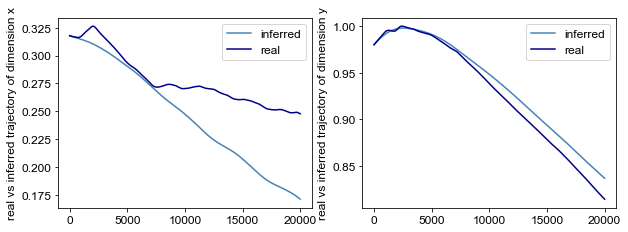

In [79]:
time1 = pd.read_csv('/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/Flocks of birds/pigeonflocks_trajectories/hf1/flocks_timeseries_2dim_hf4.csv',encoding='utf-8',header=None)
plt.rcParams.update({'font.size': 12}) 
plt.rcParams.update({'font.style': 'normal'})
plt.rcParams.update({'font.family': 'Arial'})
#plt.rcParams['savefig.dpi'] = 300 
#plt.rcParams['figure.dpi'] = 300
Nindex =0
TIME = 20000
x_tra = x_i.detach().numpy()[0:TIME,Nindex-1]
x_real = time1.iloc[0:,Nindex*2-2]
fig = plt.figure(figsize=(10,3.5))
ax1 = fig.add_subplot(1,2,1)
t = np.arange(0,x_tra.shape[0])
ax1.plot(t,x_tra,c='steelblue',label="inferred")
ax1.plot(t, x_real[2:x_tra.shape[0]+2,],c='darkblue',label="real")
plt.ylabel('real vs inferred trajectory of dimension x')
plt.legend()

ax2 = fig.add_subplot(1,2,2)
y_tra = y_i.detach().numpy()[0:TIME,Nindex-1]
y_real = time1.iloc[0:,Nindex*2-1]
t = np.arange(0,y_tra.shape[0])
ax2.plot(t,y_tra,c='steelblue',label="inferred")
ax2.plot(t, y_real[2:y_tra.shape[0]+2,],c='darkblue',label="real")
plt.ylabel('real vs inferred trajectory of dimension y')
plt.legend()

#plt.savefig('/Users/lanag/OneDrive/Project2-StochasticDynamics/StochasticRossler/Figures/weightedRossler_intensity01_average_trajectories.png')
plt.show()
#plt.close()

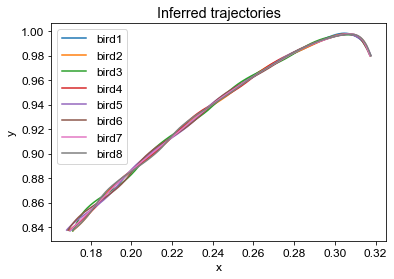

In [83]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

r = np.linspace(0, 200, 20000)
fig, ax = plt.subplots()
x1 = x_i.detach().numpy()[0:TIME,0]
y1 = y_i.detach().numpy()[0:TIME,0]
ax.plot(x1, y1, label='bird1')
#ax.scatter(x1, y1, c = plt.cm.PuBu(r/max(r)),alpha=0.5, s= 0.5)
x2 = x_i.detach().numpy()[0:TIME,1]
y2 = y_i.detach().numpy()[0:TIME,1]
ax.plot(x2, y2, label='bird2')
#ax.scatter(x2, y2, c = plt.cm.PuBu(r/max(r)),alpha=0.5, s= 0.5)
x3 = x_i.detach().numpy()[0:TIME,2]
y3 = y_i.detach().numpy()[0:TIME,2]
ax.plot(x3, y3, label='bird3')
#ax.scatter(x3, y3, c = plt.cm.PuBu(r/max(r)),alpha=0.5, s= 0.5)
x4 = x_i.detach().numpy()[0:TIME,3]
y4 = y_i.detach().numpy()[0:TIME,3]
ax.plot(x4, y4, label='bird4')
#ax.scatter(x4, y4, c = plt.cm.PuBu(r/max(r)),alpha=0.5, s= 0.5)
x5 = x_i.detach().numpy()[0:TIME,4]
y5 = y_i.detach().numpy()[0:TIME,4]
ax.plot(x5, y5, label='bird5')
#ax.scatter(x5, y5, c = plt.cm.PuBu(r/max(r)),alpha=0.5, s= 0.5)
x6 = x_i.detach().numpy()[0:TIME,5]
y6 = y_i.detach().numpy()[0:TIME,5]
ax.plot(x6, y6, label='bird6')
#ax.scatter(x6, y6, c = plt.cm.PuBu(r/max(r)),alpha=0.5, s= 0.5)
x7 = x_i.detach().numpy()[0:TIME,6]
y7 = y_i.detach().numpy()[0:TIME,6]
ax.plot(x7, y7, label='bird7')
#ax.scatter(x7, y7, c = plt.cm.PuBu(r/max(r)),alpha=0.5, s= 0.5)
x8 = x_i.detach().numpy()[0:TIME,7]
y8 = y_i.detach().numpy()[0:TIME,7]
ax.plot(x8, y8, label='bird8')
#ax.scatter(x8, y8, c = plt.cm.PuBu(r/max(r)),alpha=0.5, s= 0.5)

# x = x_real[1:20001,]
# y = y_real[1:20001,]
# ax.scatter(x, y, c = plt.cm.YlGnBu(r/max(r)),alpha=0.5, s= 1)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Inferred trajectories')
ax.legend()
#plt.savefig('/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/Flocks of birds/Figures/hf4_inferred.pdf')
plt.show()

/var/folders/tx/qq1ds3m144q1b4ghn62l4kjc0000gn/T/ipykernel_58467/2751892123.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


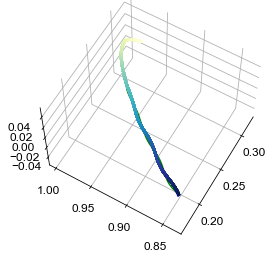

In [84]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.azim = -150
ax.dist = 9
ax.elev = 60
r = np.linspace(0, 200, 20000)


x_tra_1 = x_i.detach().numpy()[0:TIME,Nindex+1]
y_tra_1 = y_i.detach().numpy()[0:TIME,Nindex+1]
#z_tra_1 = z_i.detach().numpy()[0:TIME,Nindex+1]
x = x_tra_1#x_real[1:x_tra.shape[0]+1,]
y = y_tra_1#y_real[1:y_tra.shape[0]+1,]
#z = z_tra_1#z_real[1:z_tra.shape[0]+1,]

x_tra_2 = x_i.detach().numpy()[0:TIME,Nindex+2]
y_tra_2 = y_i.detach().numpy()[0:TIME,Nindex+2]
#z_tra_2 = z_i.detach().numpy()[0:TIME,Nindex+2]
x2 = x_tra_2#x_real[1:x_tra.shape[0]+1,]
y2 = y_tra_2 #y_real[1:y_tra.shape[0]+1,]
#z2 = z_tra_2#z_real[1:z_tra.shape[0]+1,]

x_tra_3 = x_i.detach().numpy()[0:TIME,Nindex+3]
y_tra_3 = y_i.detach().numpy()[0:TIME,Nindex+3]
#z_tra_3 = z_i.detach().numpy()[0:TIME,Nindex+3]
x3 = x_tra_3#x_real[1:x_tra.shape[0]+1,]
y3 = y_tra_3 #y_real[1:y_tra.shape[0]+1,]
#z3 = z_tra_3#z_real[1:z_tra.shape[0]+1,]


x1 = x_tra
y1 = y_tra
#z1 = z_tra

#1 colored by value of `z`
ax.plot(x, y, c = 'k') 
ax.plot(x2, y2, c = 'g') 
ax.plot(x3, y3, c = 'b') 
#2 colored by index (same in this example since z is a linspace too)

ax.scatter(x1, y1, c = plt.cm.YlGnBu(r/max(r)),alpha=0.5, s= 3)

plt.show()

In [217]:
bestMe = messages_over_time[-1]

In [218]:
import Self_func
import Interaction_func
from Self_func import *
from Interaction_func import *
from sklearn.preprocessing import normalize 
from sklearn.linear_model import LassoLarsCV 
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error 
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
from math import log
def calculate_aic(n,mse,num_params):
    aic = n * log(mse) + 2 * num_params 
    return aic 

def terms_sort_fit(X_lib,Y_goal,intercept):
    reg = LassoCV(cv=5, fit_intercept=intercept,  n_jobs=-1, max_iter=1000, normalize=False).fit(X_lib,Y_goal)
    coef = pd.Series(reg.coef_, index=X_lib.columns)
    if intercept == True:
        coef['constant'] = reg.intercept_
        num_params = len(coef)
    else:
        num_params = len(coef)    
    P = X_lib
    Score = reg.score(X_lib,Y_goal)
    yhat = reg.predict(P)
    mse = mean_squared_error(Y_goal, yhat)
    aic = calculate_aic(len(Y_goal), mse, num_params)
    #print('label of function: %.3f' % time)
    sort = coef.sort_values()
    print(coef)
    return Score, mse, aic

In [219]:
rij_val = np.sqrt(bestMe['xij'].values**2+bestMe['yij'].values**2)
cohesion_true = -((rij_val/2-1)**3/(1+rij_val/2)**6)-1#1.5*(1-(rij_val/2)**3)/(1+(rij_val/2)**6) # x1 (x_i) is target, x2 (x_j) is source 
align_true = np.exp(-rij_val/3)#np.sin(bestMe['x2'].values-bestMe['x1'].values)

## Construct interaction functions library

In [220]:
rij_matrix = self_ElementaryFunctions_Matrix(rij_val.reshape(-1,1), 1, 4, PolynomialIndex = True, TrigonometricIndex = True, \
    ExponentialIndex = False, FractionalIndex = False, ActivationIndex = True)
rij_matrix = rij_matrix.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/manuscript_code/Code/utils/Self_func.py:338: RuntimeWarning: overflow encountered in exp
  sigmoid[:,kk] = 1./(1.+np.exp(-alpha[ii]*(TimeSeries[:,j]-beta[jj])))


In [221]:
#rij_matrix['align'] = np.exp(-rij_val/3)

In [222]:
rij_matrix['cohesion'] = -((rij_val/2-1)**3/(1+rij_val/2)**6)

In [223]:
goal = bestMe['c1'].values
goal = pd.DataFrame(data = goal, columns =['c1'])

In [224]:
X = rij_matrix.copy()
y = goal.copy()
X_mat = X.values 
y_mat = y.values
x_norml1 = []
y_norml1 = []
num = np.shape(X_mat)[1]
num2 = 1
L = np.shape(X_mat)[0]

for i in range(0,num):
    x_norml1.append(sum(abs(X_mat[:,i])))

for i in range(0,num2):
    y_norml1.append(sum(abs(y_mat[:,i])))

X = pd.DataFrame(X)
y = pd.DataFrame(y)

X[X.columns] = normalize(X[X.columns], norm='l1', axis=0)*L
y[y.columns] = normalize(y[y.columns], norm='l1', axis=0)*L

X_col = X.columns 
Xin = X.iloc[:,:]
out = np.array(y)
y1 = (out[:,0])

In [225]:
maxy = np.max(bestMe['c1'].values)
miny = np.min(bestMe['c1'].values)
maxx = np.max(align_true)
minx = np.min(align_true)
align_true = (maxy-miny)*(align_true-minx)/(maxx-minx) + miny

In [226]:
reg1 = LassoCV(cv=5, fit_intercept=False, n_jobs=-1, max_iter=5000, normalize=False).fit(Xin,y1)
print(reg1.score(Xin,y1))
print('Best threshold: %.3f' % reg1.alpha_)

/opt/anaconda3/envs/pytorch_env/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


0.9775219010958722
Best threshold: 0.001


In [227]:
for i in range(len(reg1.coef_)):
    reg1.coef_[i] = reg1.coef_[i]*y_norml1[0]/x_norml1[i]
coef1 = pd.Series(reg1.coef_, index = X_col)

/var/folders/tx/qq1ds3m144q1b4ghn62l4kjc0000gn/T/ipykernel_58467/1445221178.py:2: RuntimeWarning: invalid value encountered in double_scalars
  reg1.coef_[i] = reg1.coef_[i]*y_norml1[0]/x_norml1[i]


In [228]:
imp_coef1 = pd.concat([coef1.sort_values(key=abs).head(int(0)),
                     coef1.sort_values(key=abs).tail(int(10))])
imp_cons = imp_coef1 + (1e-10)
#imp_cons['constant'] = reg1.intercept_*y_norml1[0]/L
#imp_cons = imp_cons.sort_values(key=abs)
print("Elementary functions discovered by Phase 1 with constant.")
print(imp_cons)

Elementary functions discovered by Phase 1 with constant.
regx1_5        1.000000e-10
sig_x1_101     1.000000e-10
sig_x1_105     1.000000e-10
cohesion       3.170730e-05
cosx1          2.609669e-03
x1            -7.866745e-02
x1x1          -5.519654e+00
regx1_2       -5.005555e+01
x1x1x1x1       3.110916e+06
sig_x1_1010             NaN
dtype: float64


In [230]:
xi = rij_val
Matrix = self_ElementaryFunctions_Matrix(xi.reshape(-1,1), 1, 4, PolynomialIndex = True, TrigonometricIndex = True, \
    ExponentialIndex = False, FractionalIndex = False, ActivationIndex = True)
#Matrix['align'] = np.exp(-rij_val/3)
Matrix['cohesion'] = -((rij_val/2-1)**3/(1+rij_val/2)**6)
Matrix = Matrix.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
goal = bestMe['c1'].values.reshape(-1,1)
goal = pd.DataFrame(data = goal, columns =['c1'])
for index, element in imp_cons.iteritems():
    if index != 'constant':
        Xfind = Matrix[index].values.reshape(-1,1)
        model_linear = LinearRegression(fit_intercept=True)
        model_linear.fit(Xfind,goal)
        a = model_linear.coef_
        print("Function:", index, "Coefficient:", a, "Constant:", model_linear.intercept_, "Regression score:", model_linear.score(Xfind, goal) )

Function: regx1_5 Coefficient: [[-2.36168887e+09]] Constant: [0.00259079] Regression score: 0.31013907646268135
Function: sig_x1_101 Coefficient: [[-374.31657582]] Constant: [0.0196612] Regression score: 0.9999817459383731
Function: sig_x1_105 Coefficient: [[-8.81006049e+19]] Constant: [0.01966043] Regression score: 0.9999815899174364
Function: cohesion Coefficient: [[0.03830265]] Constant: [-0.03563398] Regression score: 0.999996038818842
Function: cosx1 Coefficient: [[148.20478786]] Constant: [-148.20217128] Regression score: 0.8411532536016172
Function: x1 Coefficient: [[-0.1715856]] Constant: [0.00266847] Regression score: 0.9999999657342108
Function: x1x1 Coefficient: [[-74.21161089]] Constant: [0.00261695] Regression score: 0.8385464678304878
Function: regx1_2 Coefficient: [[-74.21212123]] Constant: [0.00261695] Regression score: 0.8385483166892085
Function: x1x1x1x1 Coefficient: [[-7965362.84222917]] Constant: [0.00259375] Regression score: 0.4204417526442088
Function: sig_x1_10

/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/manuscript_code/Code/utils/Self_func.py:338: RuntimeWarning: overflow encountered in exp
  sigmoid[:,kk] = 1./(1.+np.exp(-alpha[ii]*(TimeSeries[:,j]-beta[jj])))


In [89]:
(maxy-miny)/(maxx-minx)

0.27944395

In [90]:
minx

0.9988282

In [91]:
maxx-minx

0.0011715889

In [92]:
miny

-0.001742064

## Align

Text(0, 0.5, 'Inferred align strength')

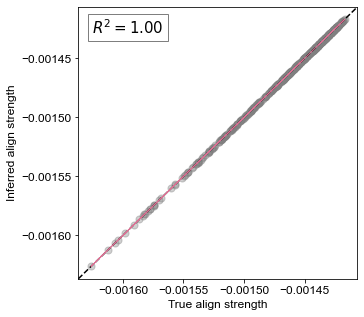

In [93]:
plt.rcParams.update({'font.size': 12}) 
plt.rcParams.update({'font.style': 'normal'})
plt.rcParams.update({'font.family': 'Arial'})
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
sx = bestMe['a1'].values[0:1000]#*bestMe['dxij']*m2
sx_true = align_true[0:1000]#*bestMe['dxij']
#sy = bestMe['a1'].values[0:5000]#*bestMe['dyij']*m2
#sy_true = align_true[0:5000]#*bestMe['dyij']
#sz = bestMe['a1'].values#*bestMe['dzij']*m2
#sz_true = align_true#*bestMe['dzij']
fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_subplot(1,1,1)
#plt.title("true align- x dimension vs. inferred",fontsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax1.scatter(sx_true,sx,s=50,c ='grey', alpha=0.2)
ax1.plot((0, 1), (0, 1), transform=ax1.transAxes, ls='--',c='k', label="1:1 line")
parameterx = np.polyfit(sx_true,sx,1)
fx = np.poly1d(parameterx)
ax1.plot(sx_true,fx(sx_true),c='palevioletred',lw=1)
corrx = np.corrcoef(sx_true,sx)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corrx**2), transform=ax1.transAxes, size=15, bbox=bbox)
plt.xlabel("True align strength")
plt.ylabel("Inferred align strength")
#plt.savefig('/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/Flocks of birds/Figures/hf4_align.pdf')

In [94]:
coup_value = -((rij_val/2-1)**3/(1+rij_val/2)**6)+1
#coup_value = ((rij_val/0.1)**3-1)/((rij_val/0.1)**6+1)

In [95]:
maxy = np.max(bestMe['c1'].values)
miny = np.min(bestMe['c1'].values)
maxx = np.max(coup_value)
minx = np.min(coup_value)
coup_value = (maxy-miny)*(coup_value-minx)/(maxx-minx) + miny

In [96]:
coup_value

array([0.00260117, 0.00248326, 0.00251343, ..., 0.00264948, 0.00251926,
       0.00261686], dtype=float32)

In [254]:
-0.01368125*(((rij_val/2-1)**3/(1+rij_val/2)**6)-1+1.9843001)+0.0025799908

array([0.00277083, 0.00272887, 0.00273961, ..., 0.00278802, 0.00274168,
       0.00277642], dtype=float32)

In [243]:
(maxy-miny)/(maxx-minx)

0.01368125

In [253]:
minx

1.9843001

In [245]:
maxx-minx

0.015696526

In [246]:
miny

0.0025799908

## Cohesion

Text(0, 0.5, 'inferred cohesion strength')

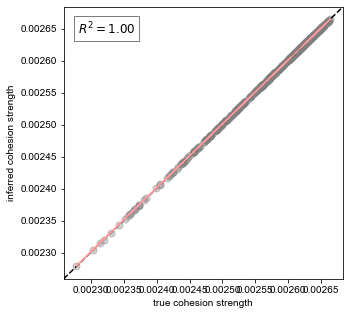

In [97]:
plt.rcParams.update({'font.size': 10}) 
plt.rcParams.update({'font.style': 'normal'})
plt.rcParams.update({'font.family': 'Arial'})
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
temp = bestMe['c1'].values[0:1000]
coup_value = coup_value[0:1000]
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1,1,1)
ax.scatter(coup_value,temp,s=50,c ='grey', alpha=0.2)
ax.plot((0, 1), (0, 1), transform=ax.transAxes, ls='--',c='k', label="1:1 line")
parameter = np.polyfit(coup_value,temp,1)
f = np.poly1d(parameter)
ax.plot(coup_value,f(coup_value),c = '#ff9999', lw=1.5)
corr = np.corrcoef(coup_value,temp)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corr**2),transform=ax.transAxes, size=12, bbox=bbox)
#plt.title('Relation-rij-cohesion')
plt.xlabel("true cohesion strength")
plt.ylabel("inferred cohesion strength")
#plt.savefig('/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/Flocks of birds/Figures/hf4_cohesion.pdf')

In [161]:
best_selfDyn = selfDyn_over_time[-1]
best_selfDyn = pd.DataFrame(best_selfDyn)
TimeSeries = best_selfDyn.iloc[:,0:dim].values
TimeSeries = TimeSeries.reshape(-1,Dimension)

In [163]:
self_true = (best_selfDyn['dxi']**2+best_selfDyn['dyi']**2)

## Construct self- functions library

In [164]:
self_matrix = self_ElementaryFunctions_Matrix(best_selfDyn.values[:,1:3], 2, 2, PolynomialIndex = True, TrigonometricIndex = False, \
    ExponentialIndex = True, FractionalIndex = False, ActivationIndex = False)
self_matrix = self_matrix.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

In [165]:
goal = best_selfDyn['s1'].values
goal = pd.DataFrame(data = goal, columns =['s1'])

In [166]:
X = self_matrix.copy()
y = goal.copy()
X_mat = X.values 
y_mat = y.values
x_norml1 = []
y_norml1 = []
num = np.shape(X_mat)[1]
num2 = 1
L = np.shape(X_mat)[0]

for i in range(0,num):
    x_norml1.append(sum(abs(X_mat[:,i])))

for i in range(0,num2):
    y_norml1.append(sum(abs(y_mat[:,i])))

X = pd.DataFrame(X)
y = pd.DataFrame(y)

X[X.columns] = normalize(X[X.columns], norm='l1', axis=0)*L
y[y.columns] = normalize(y[y.columns], norm='l1', axis=0)*L

X_col = X.columns 
Xin = X.iloc[:,:]
out = np.array(y)
y1 = (out[:,0])

In [167]:
reg1 = LassoCV(cv=5, fit_intercept=False, n_jobs=-1, max_iter=5000, normalize=False).fit(Xin,y1)
print(reg1.score(Xin,y1))
print('Best threshold: %.3f' % reg1.alpha_)

/opt/anaconda3/envs/pytorch_env/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


0.9957375357585034
Best threshold: 0.001


In [168]:
for i in range(len(reg1.coef_)):
    reg1.coef_[i] = reg1.coef_[i]*y_norml1[0]/x_norml1[i]
coef1 = pd.Series(reg1.coef_, index = X_col)

In [169]:
imp_coef1 = pd.concat([coef1.sort_values(key=abs).head(int(0)),
                     coef1.sort_values(key=abs).tail(int(10))])
imp_cons = imp_coef1 + (1e-10)
#imp_cons['constant'] = reg1.intercept_*y_norml1[0]/L
#imp_cons = imp_cons.sort_values(key=abs)
print("Elementary functions discovered by Phase 1 with constant.")
print(imp_cons)

Elementary functions discovered by Phase 1 with constant.
x2       1.000000e-10
x1x2     1.000000e-10
expx2   -2.136165e-08
expx1   -2.779635e-05
x1       1.611016e-03
x2x2    -1.135258e-01
x1x1    -1.761036e-01
dtype: float64


In [102]:
maxy = np.max(best_selfDyn['s1'].values)
miny = np.min(best_selfDyn['s1'].values)
maxx = np.max(self_true)
minx = np.min(self_true)
self_true = (maxy-miny)*(self_true-minx)/(maxx-minx) + miny

In [103]:
(maxy-miny)/(maxx-minx)

2.4716552642692085

In [104]:
minx

8.477218784719298e-07

In [105]:
maxx-minx

1.6579251109760662e-06

In [106]:
miny

-3.0189753e-05

## self

Text(0, 0.5, 'Inferred self x')

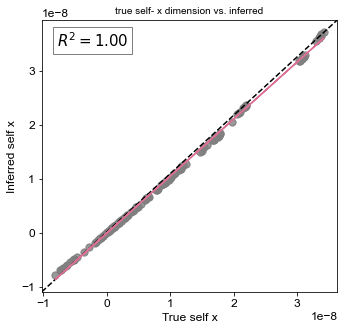

In [107]:
plt.rcParams.update({'font.size': 12}) 
plt.rcParams.update({'font.style': 'normal'})
plt.rcParams.update({'font.family': 'Arial'})
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
#self_true = 0.4*(-np.sqrt(best_selfDyn['dxi']**2+best_selfDyn['dyi']**2))
ri = np.sqrt(best_selfDyn['dxi']**2+best_selfDyn['dyi']**2)
sx = best_selfDyn['s1'].values*best_selfDyn['dxi']
sx_true = self_true*best_selfDyn['dxi']
sx = sx[0:1000]
sx_true = sx_true[0:1000]

fig = plt.figure(figsize=(18, 5))
ax1 = fig.add_subplot(1,3,1)
plt.title("true self- x dimension vs. inferred",fontsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax1.scatter(sx_true,sx,s=50,c ='grey', alpha=0.2)
ax1.plot((0, 1), (0, 1), transform=ax1.transAxes, ls='--',c='k', label="1:1 line")
parameterx = np.polyfit(sx_true,sx,1)
fx = np.poly1d(parameterx)
ax1.plot(sx_true,fx(sx_true),c='palevioletred',lw=1.5)
corrx = np.corrcoef(sx_true,sx)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corrx**2), transform=ax1.transAxes, size=15, bbox=bbox)
plt.xlabel("True self x")
plt.ylabel("Inferred self x")